In [1]:
import re
import nltk
import pandas as pd
import seaborn as sns
import string
from pickle import dump, load

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_recall_curve, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

nltk.download('punkt')
nltk.download('stopwords')

plt.style.use('dark_background')

[nltk_data] Downloading package punkt to /home/datalore/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


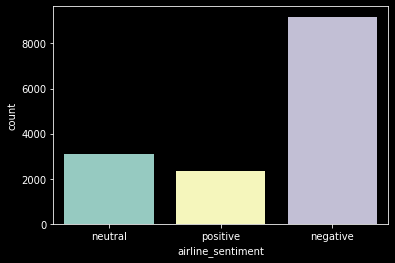

In [3]:
sns.countplot(x='airline_sentiment', data=df)

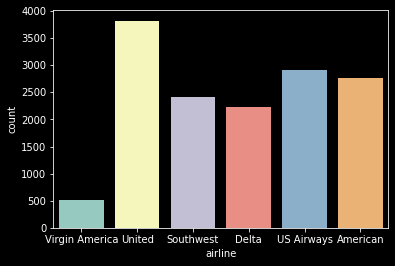

In [4]:
sns.countplot(x='airline', data=df)

In [5]:
def clean_tweet(text):
  tokens = nltk.word_tokenize(re.sub(r'[^a-zA-Z]', ' ', text))
  tokens = [word.lower() for word in tokens]
  # return ' '.join(tokens[:2])
  return ' '.join(tokens)

In [6]:
def process_text(text):
  without_punc = ''.join(char for char in text if char not in string.punctuation)
  return ' '.join(word for word in without_punc.split() if word.lower() not in stopwords.words('english'))

In [7]:
def check_scores(clf_model, x_tr, x_t, y_tr, y_t):
  model = clf_model.fit(x_tr, y_tr)
  predicted_classes = model.predict(x_t)
  predicted_classes_train = model.predict(x_tr)
  
  print('Train confusion matrix: ')
  print(confusion_matrix(y_tr, predicted_classes_train))
  print()

  print('Test confusion matrix: ')
  print(confusion_matrix(y_t, predicted_classes))
  print()

  tr_accuracy = accuracy_score(y_tr, predicted_classes_train)
  t_accuracy = accuracy_score(y_t, predicted_classes)

  print('Accuracy score: ')
  print(f'\tTrain: {tr_accuracy}')
  print(f'\tTest: {t_accuracy}')

  return tr_accuracy, t_accuracy

In [8]:
def grid_search(clf_model, parameters, x_tr, y_tr):
  grid = GridSearchCV(estimator=clf_model, param_grid=parameters, cv=2, verbose=2)

  grid.fit(x_tr, y_tr)

  optimal_model = grid.best_estimator_

  print(f'Best parameters are {grid.best_params_}')
  return optimal_model, grid.cv_results_

In [9]:
sentiment_mappings = { 'positive': 1, 'neutral': 0, 'negative': -1 }
df['cleaned_tweet'] = df['text'].apply(clean_tweet)

df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: sentiment_mappings.get(x, x))

In [10]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica what dhepburn said
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus you ve added commercials to...
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica i didn t today must mean i need ...
3,570301031407624196,-1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica it s really aggressive to blast ...
4,570300817074462722,-1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica and it s a really big bad thing ...


In [11]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(process_text)
df.reset_index(drop=True, inplace=True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica dhepburn said
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus added commercials experienc...
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica today must mean need take anothe...
3,570301031407624196,-1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...
4,570300817074462722,-1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing


In [12]:
vectorizer = TfidfVectorizer()
x_tf_idf = vectorizer.fit_transform(df.cleaned_tweet)

# Save vectorizer to file
with open('vectorizer.pkl', 'wb') as f:
  dump(vectorizer, f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_tf_idf, df.airline_sentiment, test_size=.3, random_state=42)

## SVM

In [14]:
base_svm = SVC(probability=True)
svm_model = OneVsRestClassifier(base_svm)
train_accuracy, test_accuracy = check_scores(svm_model, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6333   26    5]
 [ 197 1971   47]
 [  43   19 1607]]

Test confusion matrix: 
[[2706   64   44]
 [ 494  335   55]
 [ 216   56  422]]

Accuracy score: 
	Train: 0.9671155347384855
	Test: 0.7884790528233151


In [15]:
parameters = {
  'estimator__C': [ .1, 1.0, 10 ],
  'estimator__gamma': [ 'scale', 'auto' ],
  'estimator__kernel': [ 'rbf', 'sigmoid' ]
}
svm_optimal, results = grid_search(svm_model, parameters, x_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=rbf; total time= 1.5min
[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=rbf; total time=  44.4s
[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=sigmoid; total time= 1.5min
[CV] END estimator__C=0.1, estimator__gamma=scale, estimator__kernel=sigmoid; total time= 1.6min
[CV] END estimator__C=0.1, estimator__gamma=auto, estimator__kernel=rbf; total time= 1.1min
[CV] END estimator__C=0.1, estimator__gamma=auto, estimator__kernel=rbf; total time=  27.3s
[CV] END estimator__C=0.1, estimator__gamma=auto, estimator__kernel=sigmoid; total time=  28.1s
[CV] END estimator__C=0.1, estimator__gamma=auto, estimator__kernel=sigmoid; total time= 1.2min
[CV] END estimator__C=1.0, estimator__gamma=scale, estimator__kernel=rbf; total time= 2.3min
[CV] END estimator__C=1.0, estimator__gamma=scale, estimator__kernel=rbf; total time= 1.1m

In [16]:
svm_train_accuracy, svm_test_accuracy = check_scores(svm_model, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6333   26    5]
 [ 197 1971   47]
 [  43   19 1607]]

Test confusion matrix: 
[[2706   64   44]
 [ 494  335   55]
 [ 216   56  422]]

Accuracy score: 
	Train: 0.9671155347384855
	Test: 0.7884790528233151


In [17]:
svm_optimal_train_accuracy, svm_optimal_test_accuracy = check_scores(svm_optimal, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6355    9    0]
 [   4 2190   21]
 [   2    6 1661]]

Test confusion matrix: 
[[2621  140   53]
 [ 400  424   60]
 [ 179   72  443]]

Accuracy score: 
	Train: 0.9959016393442623
	Test: 0.7941712204007286


## Naive Bayes

In [18]:
multinomial_model = MultinomialNB()
gaussian_model = GaussianNB()

In [19]:
multinomial_train_accuracy, multinomial_test_accuracy = check_scores(multinomial_model, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6344   20    0]
 [1591  599   25]
 [1206   43  420]]

Test confusion matrix: 
[[2797   16    1]
 [ 729  146    9]
 [ 552   27  115]]

Accuracy score: 
	Train: 0.7184816549570648
	Test: 0.6962659380692168


In [20]:
gaussian_train_accuracy, gaussian_test_accuracy = check_scores(gaussian_model, x_train.toarray(), x_test.toarray(), y_train, y_test)

Train confusion matrix: 
[[4560  699 1105]
 [   0 1596  619]
 [   0    0 1669]]

Test confusion matrix: 
[[1480  550  784]
 [ 216  291  377]
 [ 153   98  443]]

Accuracy score: 
	Train: 0.7635636221701796
	Test: 0.5040983606557377


## Adaboost Classfier

In [21]:
ada_model = AdaBoostClassifier()

In [22]:
ada_train_accuracy, ada_test_accuracy = check_scores(ada_model, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[5921  234  209]
 [1553  466  196]
 [ 577  117  975]]

Test confusion matrix: 
[[2608  112   94]
 [ 629  183   72]
 [ 248   38  408]]

Accuracy score: 
	Train: 0.718384074941452
	Test: 0.7283697632058288


In [24]:
params = {
    'n_estimators': [10, 50, 100, 500],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_optimal_model = grid_search(ada_model, params,x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   1.0s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   1.0s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   4.8s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   4.6s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   9.4s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   9.1s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time= 1.0min
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  46.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   1.0s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.9s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   4.7s
[CV] END algor

In [27]:
ada_optimal_train_accuracy, ada_optimal_test_accuracy = check_scores(ada_optimal_model[0], x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6148  112  104]
 [1643  446  126]
 [ 685  122  862]]

Test confusion matrix: 
[[2715   53   46]
 [ 677  163   44]
 [ 285   56  353]]

Accuracy score: 
	Train: 0.7275565964090555
	Test: 0.735655737704918


## Bagging Classifier

In [28]:
bagging_model = BaggingClassifier(base_estimator=multinomial_model, n_estimators=100)

In [29]:
bagging_train_accuracy, bagging_test_accuracy = check_scores(bagging_model, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6344   20    0]
 [1609  581   25]
 [1210   46  413]]

Test confusion matrix: 
[[2796   18    0]
 [ 731  143   10]
 [ 553   24  117]]

Accuracy score: 
	Train: 0.7160421545667447
	Test: 0.6958105646630237


## Random Forest Classifier

In [30]:
rf_model = RandomForestClassifier()

In [31]:
rf_train_accuracy, rf_test_accuracy = check_scores(rf_model, x_train, x_test, y_train, y_test)

Train confusion matrix: 
[[6355    8    1]
 [   4 2189   22]
 [   2    5 1662]]

Test confusion matrix: 
[[2670  107   37]
 [ 508  322   54]
 [ 268   74  352]]

Accuracy score: 
	Train: 0.9959016393442623
	Test: 0.761384335154827


## Comparison 

In [32]:
data = [
    ('Random Forest', rf_train_accuracy, rf_test_accuracy),
    ('MultinomialNB', multinomial_train_accuracy, multinomial_test_accuracy),
    ('Bagged MultinomialNB', bagging_train_accuracy, bagging_test_accuracy),
    ('AdaBoost', ada_train_accuracy, ada_test_accuracy),
    ('AdaBoost Optimized', ada_optimal_train_accuracy, ada_optimal_test_accuracy),
    ('Gaussian Naive Bayes', gaussian_train_accuracy, gaussian_test_accuracy),
    ('SVM', svm_train_accuracy, svm_test_accuracy),
    ('SVM Optimized', svm_optimal_train_accuracy, svm_optimal_test_accuracy)
]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy
Model Name,,
Random Forest,0.995902,0.761384
MultinomialNB,0.718482,0.696266
Bagged MultinomialNB,0.716042,0.695811
AdaBoost,0.718384,0.728370
AdaBoost Optimized,0.727557,0.735656
Gaussian Naive Bayes,0.763564,0.504098
SVM,0.967116,0.788479
SVM Optimized,0.995902,0.794171


In [33]:
with open('model.pkl', 'wb') as f:
    dump(svm_optimal, f)